# Proyek Analisis Data: Air Quality
- **Nama:** Alfanah Muhson Husain Nugroho
- **Email:** alfanahmuhson@gmail.com

In [73]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Menentukan Pertanyaan Bisnis

- Daerah mana yang memiliki curah hujan tertinggi?
- Bagaimana kualitas udara tiap daerah?
- bagaimana konsentrasi polutan terbesar di setiap daerah?
- Bagaimana hubungan antara curah hujan dan tingkat polusi udara?

## Import Semua Packages/Library yang Digunakan

In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

## Data Wrangling

### Gathering Data

In [75]:
# Directory containing the CSV files
data_dir = "/content/drive/MyDrive/Colab Notebooks/Air-quality-dataset/PRSA_Data_20130301-20170228"

# Dictionary to store DataFrames
dfs = {}

# Load CSV files into DataFrames
for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):  # Pastikan hanya file CSV yang diproses
        name_parts = os.path.splitext(file_name)[0].split("_")
        df_name = name_parts[2] if len(name_parts) > 2 else file_name  # Gunakan nama yang lebih aman
        dfs[df_name] = pd.read_csv(os.path.join(data_dir, file_name)).drop(columns=["No"], errors="ignore")

# Menampilkan jumlah file yang dimuat
print(f"{len(dfs)} file CSV telah dimuat.")


12 file CSV telah dimuat.


In [76]:
dfs['Wanshouxigong'].head()

,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,2013,3,1,0,9.0,9.0,6.0,17.0,200.0,62.0,0.3,1021.9,-19.0,0.0,WNW,2.0,Wanshouxigong
1,2013,3,1,1,11.0,11.0,7.0,14.0,200.0,66.0,-0.1,1022.4,-19.3,0.0,WNW,4.4,Wanshouxigong
2,2013,3,1,2,8.0,8.0,NaN,16.0,200.0,59.0,-0.6,1022.6,-19.7,0.0,WNW,4.7,Wanshouxigong
3,2013,3,1,3,8.0,8.0,3.0,16.0,NaN,NaN,-0.7,1023.5,-20.9,0.0,NW,2.6,Wanshouxigong
4,2013,3,1,4,8.0,8.0,3.0,NaN,300.0,36.0,-0.9,1024.1,-21.7,0.0,WNW,2.5,Wanshouxigong


### Assessing Data

In [77]:
# Define a function to combine year, month, day, and hour into a datetime column
def combine_datetime(df):
    required_cols = {'year', 'month', 'day', 'hour'}
    if required_cols.issubset(df.columns):  # Cek apakah semua kolom tersedia
        df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
        df.set_index('datetime', inplace=True)
        df.drop(['year', 'month', 'day', 'hour'], axis=1, inplace=True)
    return df

# Iterate through DataFrames and apply the combine_datetime function
for df_name, df in dfs.items():
    dfs[df_name] = combine_datetime(df)


#### Pengecekan duplikasi data

In [78]:
duplicate_data = [(df_name, len(df), df.duplicated().sum()) for df_name, df in dfs.items()]

duplicate_stats_df = pd.DataFrame(duplicate_data, columns=["DataFrame Name", "Total Sample Count", "Duplicate Count"])

duplicate_stats_df.set_index("DataFrame Name", inplace=True)

duplicate_stats_df

,Total Sample Count,Duplicate Count
DataFrame Name,,
Aotizhongxin,35064,0
Wanliu,35064,0
Changping,35064,0
Dongsi,35064,0
Gucheng,35064,0
Shunyi,35064,0
Huairou,35064,0
Dingling,35064,0
Guanyuan,35064,0


**Insight:**
Data pada dataset air quality menunjukan tidak ada nya duplikasi data

#### Pengecekan tipe data

In [79]:
# Initialize a dictionary to store data types for each DataFrame
dtype_data = [(df_name, df.dtypes) for df_name, df in dfs.items()]

# Create a DataFrame from the collected data types
dtype_df = pd.DataFrame.from_dict(dict(dtype_data), orient='index')

# Transpose the DataFrame so that DataFrame names are rows and columns represent data types
dtype_df

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Aotizhongxin,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Wanliu,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Changping,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Dongsi,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Gucheng,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Shunyi,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Huairou,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Dingling,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Guanyuan,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
Tiantan,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object


**Insight:**
- Tipe data telah sesuai dengan yang seharusnya
- Tidak ada variable yang memiliki tipe data tidak sesuai

#### Pengecekan Missing Value

In [80]:
# Initialize a dictionary to store null value counts for each DataFrame
null_counts_data = [(df_name, df.isna().sum()) for df_name, df in dfs.items()]

# Create a DataFrame from the collected null value counts
null_counts_df = pd.DataFrame.from_dict(dict(null_counts_data), orient='index')

# Transpose the DataFrame so that DataFrame names are rows and columns represent null counts
null_counts_df


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Aotizhongxin,925,718,935,1023,1776,1719,20,20,20,20,81,14,0
Wanliu,382,284,575,1070,1812,2107,20,20,20,20,123,14,0
Changping,774,582,628,667,1521,604,53,50,53,51,140,43,0
Dongsi,750,553,663,1601,3197,664,20,20,20,20,78,14,0
Gucheng,646,381,507,668,1401,729,51,50,51,43,159,42,0
Shunyi,913,548,1296,1365,2178,1489,51,51,54,51,483,44,0
Huairou,953,777,980,1639,1422,1151,51,53,53,55,302,49,0
Dingling,779,656,730,1234,2012,1214,53,50,53,51,140,43,0
Guanyuan,616,429,474,659,1753,1173,20,20,20,20,81,14,0
Tiantan,677,597,1118,744,1126,843,20,20,20,20,78,14,0


**Insight:**
- Ditemukan banyak sekali missing value pada dataset
- terkhusus variable station dan datetime, tidak ditemukan missing value

### Cleaning Data

In [81]:
# Calculate and store the median values for each numerical column
median_values = {
    df_name: df[df.select_dtypes(include=['number']).columns.difference(['No'])].median()
    for df_name, df in dfs.items()
}

# Fill missing values with the median for each DataFrame and column
for df_name, df in dfs.items():
    numeric_columns = df.select_dtypes(include=['number']).columns.difference(['No'])
    df[numeric_columns] = df[numeric_columns].fillna(median_values[df_name])

# Loop through the DataFrames and fill missing values in 'wd' column using forward fill
for df_name, df in dfs.items():
    if 'wd' in df.columns:
        df['wd'].fillna(method='ffill', inplace=True)


<ipython-input-81-d494e3fbf18a>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['wd'].fillna(method='ffill', inplace=True)
<ipython-input-81-d494e3fbf18a>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['wd'].fillna(method='ffill', inplace=True)


**Penjelasan :**
<br>untuk proses cleaning data pertama-tama menghitung nilai median untuk setiap kolom numerik dalam setiap DataFrame, kecuali kolom 'No', lalu mengisi nilai yang hilang (NaN) dengan median tersebut. Setelah itu, jika kolom 'wd' ada dalam DataFrame, nilai yang hilang dalam kolom tersebut diisi menggunakan metode forward fill (ffill), yang menggantinya dengan nilai dari baris sebelumnya. Dengan cara ini, data tetap konsisten dan nilai yang hilang diatasi dengan metode yang sesuai berdasarkan jenisnya.

Memastikan bahwa tidak ada lagi data yang memiliki missing value

In [82]:
# Initialize a dictionary to store null value counts for each DataFrame
null_counts_data = [(df_name, df.isna().sum()) for df_name, df in dfs.items()]

# Create a DataFrame from the collected null value counts
null_counts_df = pd.DataFrame.from_dict(dict(null_counts_data), orient='index')

# Transpose the DataFrame so that DataFrame names are rows and columns represent null counts
null_counts_df


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
Aotizhongxin,0,0,0,0,0,0,0,0,0,0,0,0,0
Wanliu,0,0,0,0,0,0,0,0,0,0,0,0,0
Changping,0,0,0,0,0,0,0,0,0,0,0,0,0
Dongsi,0,0,0,0,0,0,0,0,0,0,0,0,0
Gucheng,0,0,0,0,0,0,0,0,0,0,0,0,0
Shunyi,0,0,0,0,0,0,0,0,0,0,0,0,0
Huairou,0,0,0,0,0,0,0,0,0,0,0,0,0
Dingling,0,0,0,0,0,0,0,0,0,0,0,0,0
Guanyuan,0,0,0,0,0,0,0,0,0,0,0,0,0
Tiantan,0,0,0,0,0,0,0,0,0,0,0,0,0


## Exploratory Data Analysis (EDA)

### Explore median dan mean dari setiap variable

In [83]:
# Create a dictionary to store mean values for each parameter
mean_values = {
    df_name: df.mean(numeric_only=True) for df_name, df in dfs.items()
}

# Create a DataFrame from the dictionary of mean values
mean_values_df = pd.DataFrame.from_dict(mean_values, orient='index')

mean_values_df


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
Aotizhongxin,82.120075,109.588187,17.152554,59.121859,1244.561887,55.649690,13.585130,1011.846665,3.123449,0.067383,1.708373
Wanliu,83.109169,110.282666,18.239118,65.098314,1297.682609,47.859676,13.429362,1011.097366,3.267006,0.068224,1.501095
Changping,70.545694,94.281790,14.816361,44.026443,1137.019279,57.734328,13.687644,1007.759764,1.505941,0.060278,1.853402
Dongsi,85.655404,109.952923,18.369798,53.393550,1299.974703,56.962841,13.672019,1012.547221,2.447850,0.063983,1.860641
Gucheng,83.412651,118.646161,15.245193,55.759226,1307.034309,57.430945,13.865885,1008.829122,2.611008,0.064374,1.342899
Shunyi,78.853887,98.397308,13.255208,43.639911,1163.021504,54.683189,13.389441,1013.061412,2.466014,0.061006,1.807147
Huairou,69.011408,90.984486,11.894565,32.146806,1013.528976,59.469384,12.447105,1007.598117,2.239317,0.067833,1.651529
Dingling,65.434317,83.295585,11.609128,27.283320,887.400896,68.287028,13.687644,1007.759764,1.505941,0.060278,1.853402
Guanyuan,82.512914,108.778322,17.461290,57.771932,1252.731776,55.300104,13.585130,1011.846665,3.123449,0.067383,1.708373
Tiantan,81.717653,105.999934,14.132702,53.031884,1285.512720,55.600006,13.672019,1012.547221,2.447850,0.063983,1.860641


In [84]:
# Create a dictionary to store median values for each parameter
median_values = {
    df_name: df.median(numeric_only=True) for df_name, df in dfs.items()
}

# Create a DataFrame from the dictionary of median values
median_values_df = pd.DataFrame.from_dict(median_values, orient='index')

median_values_df


,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
Aotizhongxin,58.0,87.0,9.0,53.0,900.0,42.0000,14.5,1011.4,3.8,0.0,1.4
Wanliu,59.0,88.0,10.0,60.0,900.0,32.0000,14.3,1010.8,4.0,0.0,1.2
Changping,46.0,72.0,7.0,36.0,800.0,46.0000,14.7,1007.4,1.8,0.0,1.5
Dongsi,61.0,86.0,10.0,47.0,1000.0,44.1252,14.6,1012.2,3.0,0.0,1.5
Gucheng,60.0,99.0,7.0,50.0,900.0,45.0000,14.8,1008.5,3.0,0.0,1.0
Shunyi,55.0,77.0,5.0,37.0,800.0,43.0000,14.4,1012.7,3.1,0.0,1.5
Huairou,47.0,69.0,4.0,25.0,800.0,49.0000,13.6,1007.3,2.7,0.0,1.3
Dingling,41.0,60.0,5.0,19.0,600.0,61.0000,14.7,1007.4,1.8,0.0,1.5
Guanyuan,59.0,89.0,8.0,51.0,900.0,41.0000,14.5,1011.4,3.8,0.0,1.4
Tiantan,59.0,85.0,7.0,47.0,900.0,40.0000,14.6,1012.2,3.0,0.0,1.5


### Penggabungan data dan deskripsi dataset

In [85]:
all_data = pd.concat(dfs.values(), keys=dfs.keys()).reset_index().rename(columns={'level_0': 'station'})
all_data = all_data.loc[:, ~all_data.columns.duplicated()]

all_data.describe(include="all")

,station,datetime,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM
count,420768,420768,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768.000000,420768,420768.000000
unique,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN
top,Aotizhongxin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE,NaN
freq,35064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43653,NaN
mean,NaN,2015-03-01 11:30:00.000001024,79.273026,104.235659,15.642997,50.384959,1212.909829,56.925748,13.539869,1010.746005,2.491120,0.064416,NaN,1.729444
min,NaN,2013-03-01 00:00:00,2.000000,2.000000,0.285600,1.026500,100.000000,0.214200,-19.900000,982.400000,-43.400000,0.000000,NaN,0.000000
25%,NaN,2014-03-01 05:45:00,21.000000,36.000000,3.000000,23.000000,500.000000,12.000000,3.100000,1002.300000,-8.900000,0.000000,NaN,0.900000
50%,NaN,2015-03-01 11:30:00,55.000000,82.000000,7.000000,43.000000,900.000000,44.000000,14.500000,1010.400000,3.000000,0.000000,NaN,1.400000
75%,NaN,2016-02-29 17:15:00,109.000000,144.000000,19.000000,70.000000,1500.000000,80.000000,23.200000,1019.000000,15.100000,0.000000,NaN,2.200000
max,NaN,2017-02-28 23:00:00,999.000000,999.000000,500.000000,290.000000,10000.000000,1071.000000,41.600000,1042.800000,29.100000,72.500000,NaN,13.200000


**Insight:**
- stasiun pemantauan Aotizhongxin memiliki pencatatan air quality terbanyak
- pencatatan terjadi dari tahun 2013 hingga tahun 2017
- polutan terbesar adalah CO
- suhu tertinggi yang tercatat adalah 41,6 derajat celcius dan curah hujan tertinggi berada di angka 72,5 mm

## Visualization & Explanatory Analysis

### Pertanyaan 1: Daerah mana yang memiliki curah hujan tertinggi?

In [86]:
all_data.groupby(by="station").agg({
    "RAIN": ["max", "min"],
})

RAIN     
                max  min
station                 
Aotizhongxin   72.5  0.0
Changping      52.1  0.0
Dingling       52.1  0.0
Dongsi         46.4  0.0
Guanyuan       72.5  0.0
Gucheng        41.9  0.0
Huairou        45.9  0.0
Nongzhanguan   46.4  0.0
Shunyi         37.3  0.0
Tiantan        46.4  0.0
Wanliu         72.5  0.0
Wanshouxigong  46.4  0.0

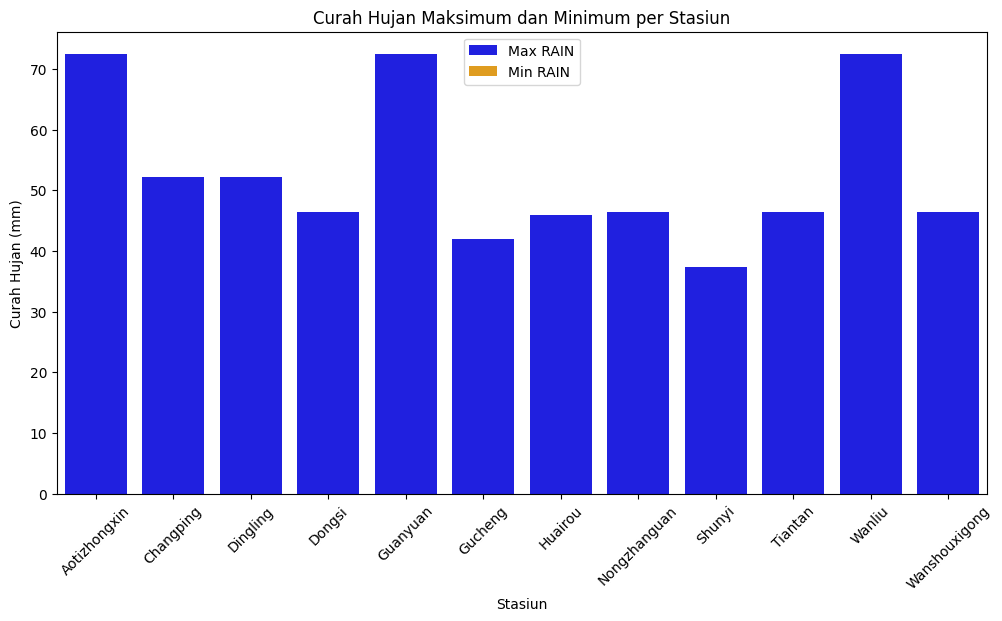

In [87]:
rain_stats = all_data.groupby(by="station").agg({
    "RAIN": ["max", "min"]
})

rain_stats.columns = ["Max RAIN", "Min RAIN"]

# Reset index agar data lebih mudah diproses
rain_stats = rain_stats.reset_index()

# Membuat plot
plt.figure(figsize=(12, 6))
sns.barplot(x="station", y="Max RAIN", data=rain_stats, color="blue", label="Max RAIN")
sns.barplot(x="station", y="Min RAIN", data=rain_stats, color="orange", label="Min RAIN")

# Atur label dan judul
plt.title("Curah Hujan Maksimum dan Minimum per Stasiun")
plt.xlabel("Stasiun")
plt.ylabel("Curah Hujan (mm)")
plt.xticks(rotation=45)
plt.legend()

# Tampilkan plot
plt.show()


Curah Hujan tertinggi terjadi berada pada stasiun Aotizhongxin, Guanyuan, dan Wanliu.

### Pertanyaan 2: Bagaimana kualitas udara tiap daerah?

In [88]:
category_ranges = [
    'Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous'
]
pm25_ranges = [12, 35.4, 150.4, 250.4, float('inf')]
pm10_ranges = [54, 154, 254, 354, 424, float('inf')]
so2_ranges = [35, 75, 185, 304, 604, float('inf')]
no2_ranges = [53, 100, 360, 649, 1249, float('inf')]
co_ranges = [4400, 9400, 12400, 15400, 30400, float('inf')]
o3_ranges = [54, 70, 85, 105, 200, float('inf')]

# Define a function to categorize a value based on the given ranges
def categorize(value, ranges):
    for max_val in ranges:
        if value <= max_val:
            return ranges.index(max_val)

# Create a new column 'Category' by applying the categorize function to each row
all_data['Category'] = all_data.apply(lambda row: category_ranges[max(
    categorize(row['PM2.5'], pm25_ranges),
    categorize(row['PM10'], pm10_ranges),
    categorize(row['SO2'], so2_ranges),
    categorize(row['NO2'], no2_ranges),
    categorize(row['CO'], co_ranges),
    categorize(row['O3'], o3_ranges),
)], axis=1)


all_data.sample(5)

,station,datetime,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,Category
335031,Tiantan,2015-05-20 15:00:00,15.0,20.0,2.0,22.0,300.0,117.0,28.800,1009.5,0.5,0.0,WNW,4.3,Very Unhealthy
417037,Wanshouxigong,2016-09-26 13:00:00,52.0,52.0,2.0,59.0,1500.0,36.0,19.425,1010.0,18.2,0.0,NE,1.4,Unhealthy for Sensitive Groups
355621,Nongzhanguan,2013-09-24 13:00:00,4.0,11.0,6.0,20.0,300.0,52.0,20.600,1016.5,-0.7,0.0,NW,3.3,Good
263032,Dingling,2015-03-03 16:00:00,9.0,104.0,2.0,2.0,300.0,84.0,4.100,1013.9,-27.4,0.0,NNW,3.7,Unhealthy for Sensitive Groups
132997,Dongsi,2016-05-02 13:00:00,51.0,58.0,2.0,30.0,1900.0,71.0,12.200,1006.8,8.8,1.2,NNW,3.0,Unhealthy for Sensitive Groups


In [89]:
category_counts = pd.crosstab(all_data['station'], all_data['Category'])
station_air_quality = category_counts[category_ranges]
category_counts[category_ranges]

Category,Good,Moderate,Unhealthy for Sensitive Groups,Unhealthy,Very Unhealthy,Hazardous
station,,,,,,
Aotizhongxin,1623,6309,14257,5723,5641,1511
Changping,2238,7943,13447,5217,4972,1247
Dingling,1686,7073,13464,6084,5518,1239
Dongsi,1953,6166,13804,5760,6026,1355
Guanyuan,1989,6462,13909,5596,5639,1469
Gucheng,1339,5864,14475,6078,5734,1574
Huairou,2142,7281,14280,5323,4762,1276
Nongzhanguan,1735,6065,13696,5750,6061,1757
Shunyi,2044,6747,14746,5244,4983,1300


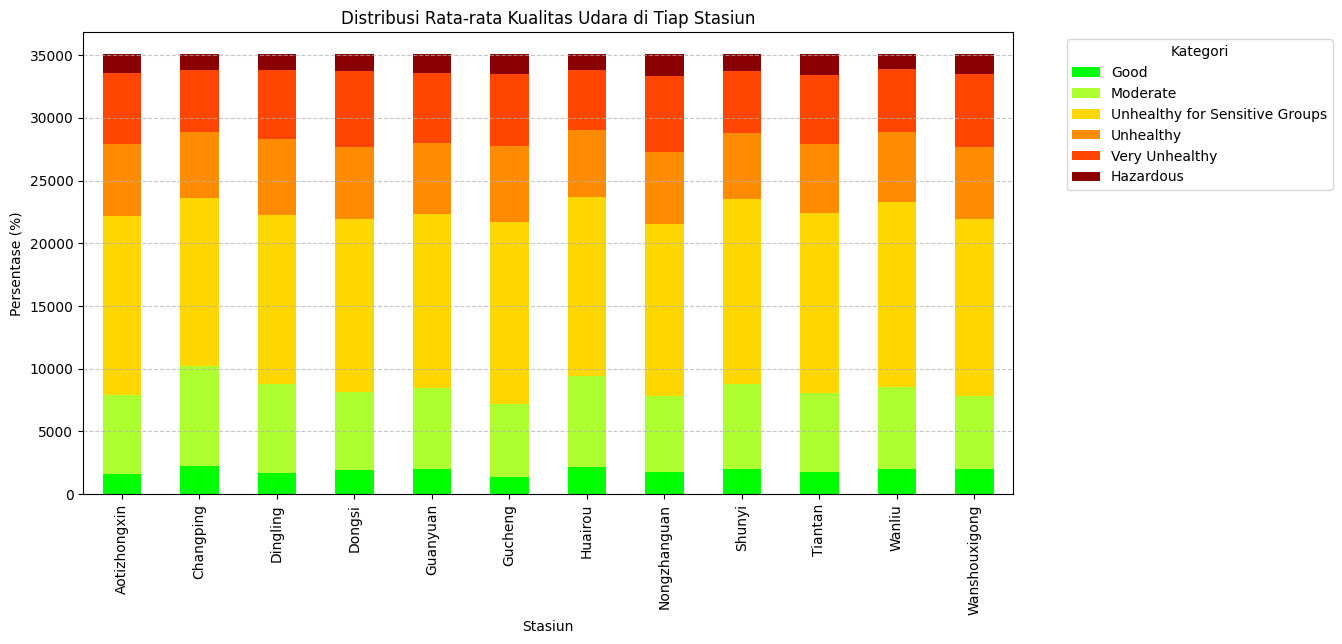

In [90]:
station_air_quality = station_air_quality[category_ranges]

# Warna kategori kualitas udara (hijau ke merah)
category_colors = {
    "Good": "#00FF00",         # Hijau
    "Moderate": "#ADFF2F",      # Hijau kekuningan
    "Unhealthy for Sensitive Groups": "#FFD700",  # Kuning
    "Unhealthy": "#FF8C00",     # Oranye
    "Very Unhealthy": "#FF4500", # Merah tua
    "Hazardous": "#8B0000"      # Merah gelap
}

# Buat stacked bar chart
station_air_quality.plot(kind='bar', stacked=True, figsize=(12, 6), color=[category_colors[c] for c in category_ranges])

# Atur label dan judul
plt.title("Distribusi Rata-rata Kualitas Udara di Tiap Stasiun")
plt.xlabel("Stasiun")
plt.ylabel("Persentase (%)")
plt.legend(title="Kategori", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.show()

**Insight:**
- Daerah dengan rata - rata kualitas udara good adalah kota Changping
- Daerah dengan rata - rata kualitas udara hazardous adalah kota Nongzhanguan

## Pertanyaan 3:

In [91]:
pollutant_mean = all_data.groupby(by="station").agg({
    "SO2": ["mean"],
    "NO2": ["mean"],
    "CO": ["mean"],
    "O3": ["mean"]
})

pollutant_mean['kadar_polusi'] = pollutant_mean.mean(axis=1)

print(pollutant_mean)

                     SO2        NO2           CO         O3 kadar_polusi
                    mean       mean         mean       mean             
station                                                                 
Aotizhongxin   17.152554  59.121859  1244.561887  55.649690   344.121497
Changping      14.816361  44.026443  1137.019279  57.734328   313.399103
Dingling       11.609128  27.283320   887.400896  68.287028   248.645093
Dongsi         18.369798  53.393550  1299.974703  56.962841   357.175223
Guanyuan       17.461290  57.771932  1252.731776  55.300104   345.816275
Gucheng        15.245193  55.759226  1307.034309  57.430945   358.867418
Huairou        11.894565  32.146806  1013.528976  59.469384   279.259932
Nongzhanguan   18.565999  57.957107  1309.754991  58.339367   361.154366
Shunyi         13.255208  43.639911  1163.021504  54.683189   318.649953
Tiantan        14.132702  53.031884  1285.512720  55.600006   352.069328
Wanliu         18.239118  65.098314  1297.682609  4

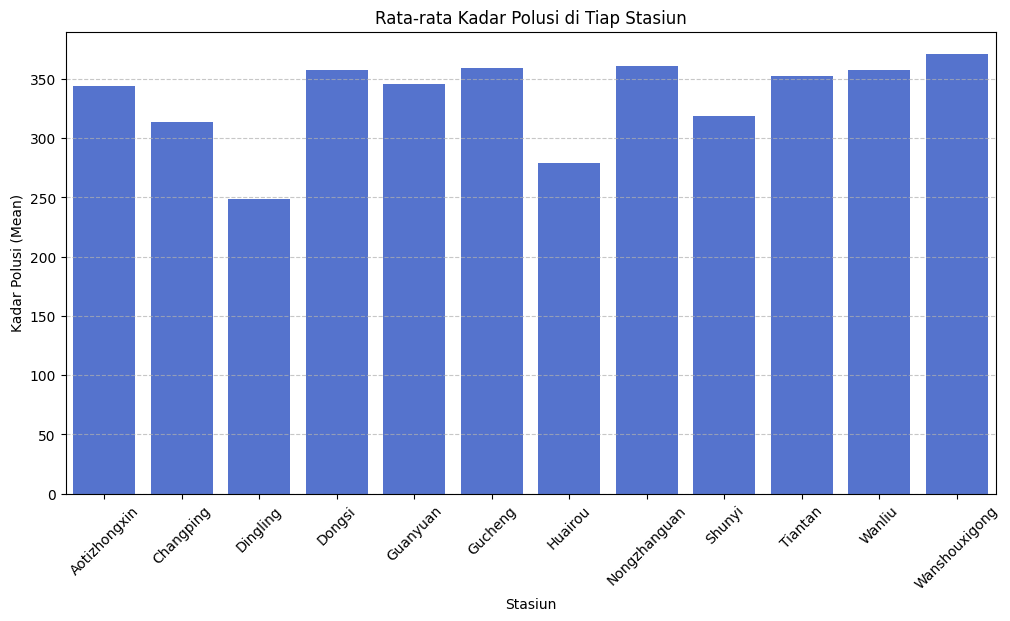

In [92]:
# Reset index agar bisa digunakan dalam plot
pollutant_mean = pollutant_mean.reset_index()

# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x="station", y="kadar_polusi", data=pollutant_mean, color="royalblue")

# Tambahkan label dan judul
plt.title("Rata-rata Kadar Polusi di Tiap Stasiun")
plt.xlabel("Stasiun")
plt.ylabel("Kadar Polusi (Mean)")
plt.xticks(rotation=45)  # Putar label stasiun agar lebih terbaca
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tampilkan plot
plt.show()

**Insight:**
- Stasiun Wanshouxigong memiliki konsentrasi polusi tertinggi dengan rata-rata polutan sebesar 374,83
- Stasiun Dingling memiliki konsentrasi polusi terendah dengan rata-rata polutan sebesar 253,19

## Pertanyaan 4 : Bagaimana hubungan antara curah hujan dan tingkat polusi udara?

<ipython-input-93-d140f49af800>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = all_data.groupby(["Rain_Category", "Category"]).size().unstack()


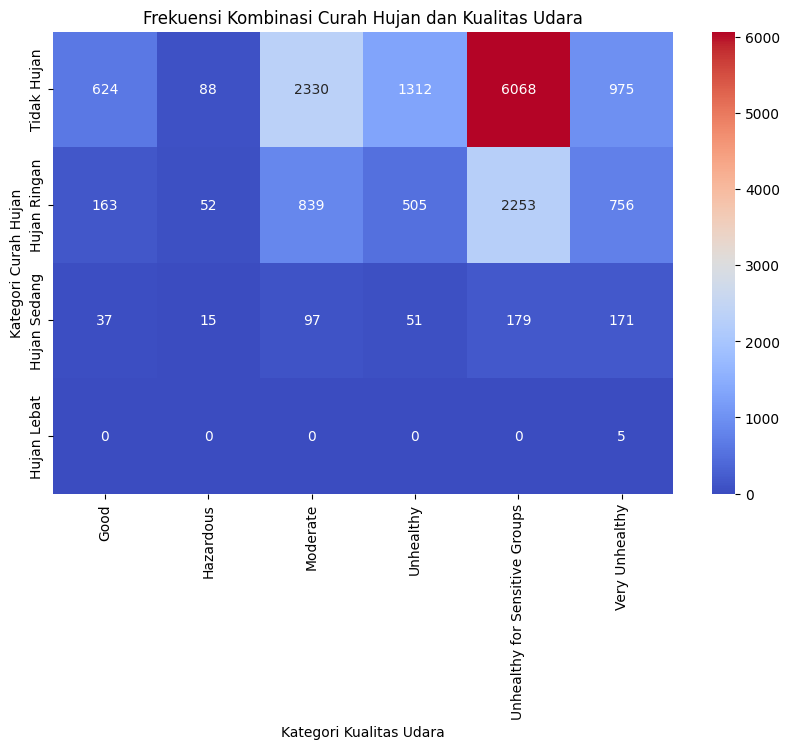

In [93]:
rain_bins = [0, 1, 10, 50, float('inf')]
rain_labels = ["Tidak Hujan", "Hujan Ringan", "Hujan Sedang", "Hujan Lebat"]
all_data["Rain_Category"] = pd.cut(all_data["RAIN"], bins=rain_bins, labels=rain_labels)

# Gunakan kategori kualitas udara yang sudah dibuat sebelumnya
# Pastikan kategori Good - Hazardous sudah ada dalam all_data["Category"]

# Buat tabel frekuensi untuk heatmap
heatmap_data = all_data.groupby(["Rain_Category", "Category"]).size().unstack()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="coolwarm")

plt.title("Frekuensi Kombinasi Curah Hujan dan Kualitas Udara")
plt.xlabel("Kategori Kualitas Udara")
plt.ylabel("Kategori Curah Hujan")
plt.show()


**Insight:** Secara umum, kualitas udara cenderung memburuk saat tidak ada hujan, dan membaik seiring dengan meningkatnya intensitas curah hujan. Kondisi kualitas udara terburuk (Unhealthy for Sensitive Groups dan Very Unhealthy) paling sering terjadi saat tidak hujan. Hujan lebat tampaknya berkorelasi dengan kondisi kualitas udara yang lebih baik, meskipun tidak berarti selalu menghasilkan kualitas udara "Baik".

In [94]:
all_data.to_csv("all_data.csv", index=False)

## Conclusion

- pemantauan air quality terjadi di 12 titik stasiun pemantauan
- stasiun pemantauan Aotizhongxin memiliki pencatatan air quality terbanyak
- pencatatan terjadi dari tahun 2013 hingga tahun 2017
- polutan terbesar adalah CO
- suhu tertinggi yang tercatat adalah 41,6 derajat celcius dan curah hujan tertinggi berada di angka 72,5 mm
- Curah Hujan tertinggi terjadi berada pada stasiun Aotizhongxin, Guanyuan, dan Wanliu.
- Daerah dengan rata - rata kualitas udara good adalah kota Changping
- Daerah dengan rata - rata kualitas udara hazardous adalah kota Nongzhanguan
- Stasiun Wanshouxigong memiliki konsentrasi polusi tertinggi dengan rata-rata polutan sebesar 374,83
- Stasiun Dingling memiliki konsentrasi polusi terendah dengan rata-rata polutan sebesar 253,19
- Secara umum, kualitas udara cenderung memburuk saat tidak ada hujan, dan membaik seiring dengan meningkatnya intensitas curah hujan.